# Getting started with FAIRiCube Hub
Authors: Maria Ricci, Manuel Löhnertz ([space4environment](https://space4environment.com/))

-----

In this demo you will see
- how to ingest raster data to SentinelHub
- how to request data from SentinelHub
- how to process a simple data cube and compute zonal statistics

The objective of this demo is to compute the share of Urban Atlas classes in a sample city.

We will use the following data:
- Urban Audit City
- Urban Atlas
- city bounding boxes lookup table

As bonus, you will see how to combine a private ingested dataset (Urban Audit City) with a publicly available EDC dataset (population density).

### Load required packages and secrets

In [1]:
%matplotlib inline

# Utilities
import matplotlib.pyplot as plt
import pandas as pd
import os
import shapely.geometry
import IPython.display

# Sentinel Hub
from sentinelhub import (
    CRS,
    BBox,
    ByocCollection,
    ByocTile,
    DataCollection,
    MimeType,
    SentinelHubBYOC,
    SentinelHubRequest,
    SHConfig,
    bbox_to_dimensions,
    Geometry
)

config = SHConfig()
config.instance_id = os.environ.get("SH_INSTANCE_ID")
config.sh_client_id = os.environ.get("SH_CLIENT_ID")
config.sh_client_secret = os.environ.get("SH_CLIENT_SECRET")
config.aws_access_key_id = os.environ.get("username")
config.aws_secret_access_key = os.environ.get("password")

## Ingest data to SentinelHub
### Dataset preparation
We will ingest the CLMS Urban Atlas Land Cover/Land Use 2018 dataset. 
Preprocessing steps:
- the [original dataset](https://land.copernicus.eu/en/products/urban-atlas/urban-atlas-2018) has been first rasterized to 10m resolution
- the raster Tiff file has been converted to Cloud Optimized GeoTiff format (COG) and tiled. See `pre-processing\gdal_tiff_to_tiled_cog.md` for further information
- the COG tiles have been saved in the UC1 s3 bucket
  
### Ingestion
To ingest the dataset in SentinelHub, we first create an empty collection, and then upload the tiles. This step can take some time, depending on the service availabilty. When a tile has finished uploading, its status changes to "INGESTED".

In [2]:
# Initialize SentinelHubBYOC class
byoc = SentinelHubBYOC(config=config)

new_collection = ByocCollection(name="UrbanAtlas2018_10m_raster_demo", s3_bucket="hub-fairicube0")
created_collection = byoc.create_collection(new_collection)
my_collection = byoc.get_collection(created_collection["id"])


# path to collection tiles
input_folder ="data/d002_urban_atlas"
tile_list = [
        "ua2018_mosaic_raster_10m_cog_5_6_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_5_5_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_5_4_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_5_3_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_5_2_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_5_1_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_4_6_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_4_5_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_4_4_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_4_3_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_4_2_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_4_1_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_3_6_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_3_5_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_3_4_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_3_3_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_3_2_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_3_1_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_2_6_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_2_5_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_2_4_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_2_3_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_2_2_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_2_1_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_1_6_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_1_5_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_1_4_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_1_3_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_1_2_(BAND).tif",
        "ua2018_mosaic_raster_10m_cog_1_1_(BAND).tif"
            ]

# ingest tiles
for tile in tile_list:
    path_link = input_folder+"/"+tile
    new_tile = ByocTile(path=path_link) 
    created_tile = byoc.create_tile(created_collection, new_tile)
    tile = byoc.get_tile(collection=created_collection["id"], tile=created_tile["id"])

Check the ingestion status

In [12]:
# check ingestion status
# tile ingestion can take a few minutes
collections_iterator = byoc.iter_collections("UrbanAtlas2018_10m_raster_demo")
my_collection = list(collections_iterator)[0]
print("Collection name:", my_collection["name"])
print("Collection id: ", my_collection["id"])
tiles = list(byoc.iter_tiles(my_collection))
for tile in tiles:
    print("Tile status: ", tile['status'])
    print("Tile created: ", tile['created'])

Collection name: UrbanAtlas2018_10m_raster_demo
Collection id:  85c901ac-78c3-4cb3-af8c-892d2b362049
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:20.848577Z
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:19.646812Z
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:18.186341Z
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:18.499661Z
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:20.147246Z
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:20.348365Z
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:18.292628Z
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:19.945336Z
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:18.707875Z
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:19.332111Z
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:20.748545Z
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:18.608296Z
Tile status:  INGESTED
Tile created:  2023-04-18T08:40:19.847494Z
Tile status:  INGESTED
Tile created:  202

In [4]:
# delete collection
# byoc.delete_collection(my_collection)

### Ingestion validation
Before starting to process, we check whether the ingested data corresponds to the original data. 
To check metadata and statistics, we can use the validation tool `pre-processing\quality_check.py` (still in development).
Quality assessment can be done by visually inspecting a small sample area.

## Use data from SentinelHub

Let's see all ingested collections. We can optionally print the datail of the tiles as well.

In [11]:
# list all ingested collections
collections_iterator = byoc.iter_collections()
my_collections = list(collections_iterator)
for collection in my_collections:
    
    print("Collection name:", collection["name"])
    print("Collection id: ", collection["id"])
#     tiles = list(byoc.iter_tiles(collection))
#     for tile in tiles:
#         print("Tile status: ", tile['status'])
#         print("Tile created: ", tile['created'])
#         print("Tile path: ", tile['path'])
#         if(tile['status'] == "FAILED"):
#             print("Ingestion failed error: ", tile['additionalData'])
    print("-------------------")

Collection name: urban_audit_2021_city
Collection id:  20774d38-7b2e-43e9-b574-66fa2954da1c
-------------------
Collection name: nuts3_2021
Collection id:  81a17892-38ff-470a-ae46-b64313acd7b3
-------------------
Collection name: UrbanAtlas2018_10m_raster_demo
Collection id:  85c901ac-78c3-4cb3-af8c-892d2b362049
-------------------
Collection name: urban_audit_2021_fua
Collection id:  b17f90da-1308-439e-b675-6e3a87f883de
-------------------
Collection name: nuts3_2021
Collection id:  ed7c0bf4-e85f-498c-ad18-f3e83fb89a6f
-------------------


We are ready to build our first cube!

We can query data by a given bounding box, or define a geometry. Here we get the geometry and the bounding box from the UC1 database.

In [ ]:
from src import db_connect
from sqlalchemy import text
import geopandas as gpd

home_dir = os.environ.get('HOME')
engine_postgresql = db_connect.create_engine(db_config = f"{home_dir}/uc1-urban-climate/database.ini")

with engine_postgresql.begin() as conn:
    query = text("""
              SELECT urau_code, urau_name, geometry
              FROM lut.l_city_urau2021
              """)
    gdf = gpd.read_postgis(query, conn, geom_col='geometry')

row = gdf[gdf.urau_name == 'Verona']
geometry_gdf = row.geometry # input argument
bbox_coords = geometry_gdf.bounds.minx, geometry_gdf.bounds.miny, geometry_gdf.bounds.maxx, geometry_gdf.bounds.maxy # input argument (or compute from geometry)

geometry = Geometry(geometry=geometry_gdf.item(), crs=CRS.WGS84) # define here your geometry
bbox = BBox(bbox=bbox_coords, crs=CRS.WGS84) # define here your bounding box
bbox_size = bbox_to_dimensions(bbox, resolution=10)

Plot the bounding box

In [6]:
# plot bounding box
IPython.display.GeoJSON(shapely.geometry.box(*bbox.transform_bounds(CRS.WGS84)).__geo_interface__)

<IPython.display.GeoJSON object>

Define the dimensions. In SentinelHub, each collection has a unique `collectionId`. We listed all collection´names and ids above.

In [15]:
# Urban atlas
collection_id_UA = "85c901ac-78c3-4cb3-af8c-892d2b362049"
collection_name_UA = "UrbanAtlas2018_10m_raster_demo"
data_collection_UA = DataCollection.define_byoc(collection_id_UA, name=collection_name_UA)

The last ingredient for the SentinelHub request is the `evalscript`, which tells SH how to deliver the datacube. Here, we want to simply get the two collections in two separate layers. See later for a more complex `evalscript`.

In [16]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B01"],
    output: { 
        bands: 1,
        sampleType: "UINT16" // raster format will be UINT16
        }
    
  };
}

function evaluatePixel(sample) {
  return [sample.B01];
}
"""
input_data = [
        SentinelHubRequest.input_data(
            data_collection=DataCollection.UrbanAtlas2018_10m_raster_demo,
            identifier="UA",
        )
    ]
request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=input_data,
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        geometry=geometry, # comment out to get data within the bounding box
        size=bbox_size,
        config=config
    )

data = request.get_data()[0]

In [ ]:
from src import utils
utils.plot_image(data, cmap='Greens')

The request returns a 3d numpy array.

In [19]:
# check dimensions and type
print(data.shape, type(data))

(2169, 1902, 2) <class 'numpy.ndarray'>


## Compute zonal statistics
For each Urban Atlas class, we compute the number of pixels within the city. The result is a pandas DataFrame, which we can later save as .csv, or directly into the database.

Check out the demo notebook `demo_urban_profile_viz.ipynb` for a visualization of the result.

In [28]:
# compute accounting table
b1 = data[:,:,0]
b2 = data[:,:,1]

bands2df = {
    "urban_atlas_2018": pd.Series(b2.ravel())
   }

df = pd.DataFrame(data=bands2df)
combine_table_cube_urban=df.groupby(['urban_atlas_2018']).size().reset_index().rename(columns={0:'count'})

Let's plot the DataFrame. Each row gives the pixel count for a combination of a Urban Atlas class and a city code.

The column `city_code` has either the numerical code for Verona (608), or the nodata value (65535). That means that we computed the pixel count for each Urban Atlas class within the city (city_code = 608) and outside of the city (city_code = 65535). The latter rows can therefore be discarded.

More information about the Urban Atlas classes can be found in the mapping guide: https://land.copernicus.eu/user-corner/technical-library/urban-atlas-mapping-guide

In [29]:
combine_table_cube_urban

,city_code,urban_atlas_2018,count
0,608,11100,67326
1,608,11210,90336
2,608,11220,51197
3,608,11230,40915
4,608,11240,9583
5,608,11300,41268
6,608,12100,264899
7,608,12210,7365
8,608,12220,103924
9,608,12230,18936


## Bonus: Request data from EDC catalog

So far we have used our own collections. But it is possible to request other publicly available collections in the same way. 

Let's combine the city dimension with the population density dataset, which is available in the EuroDataCube catalog: https://collections.eurodatacube.com/population_density/.

In the catalog we find the SentinelHub CollectionId, which we use to request the collection.

In [31]:
# population density
# https://collections.eurodatacube.com/population_density/
data_collection_pop = DataCollection.define_byoc("b468089b-2627-4787-b984-89c10434f6c6")

In this request we combine the two collections into one single dimension.

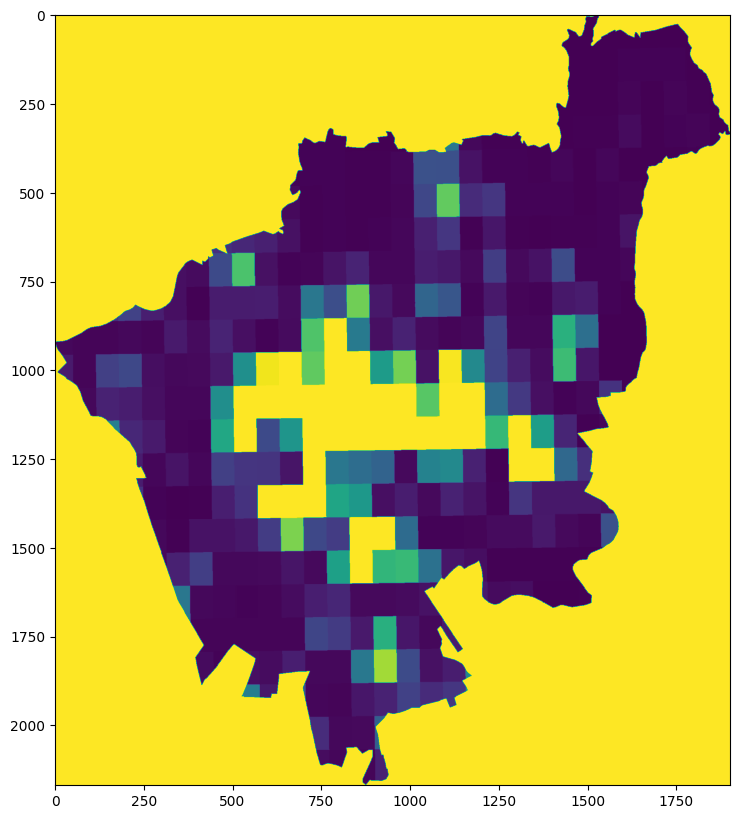

In [37]:
evalscript_combi = """
//VERSION=3
function setup() {
  return {
    input: [{
        datasource: "UA",
        bands: ["B1"]
      },
      {
        datasource: "pop",
        bands: ["populationDensity"]
      }],
    output: [{
      bands: 1,
      sampleType: "UINT16" // raster format will be UINT16
    }]
  }
}


function evaluatePixel(samples, inputData, inputMetadata, customData, outputMetadata) {
  var UA = samples.UA[0]
  var pop = samples.pop[0]
  
  if(UA.B1 == null) {
      return [65535];
  }
  else {
      return [UA.B1*1000+pop.populationDensity];
  }
}
"""

request = SentinelHubRequest(
    evalscript=evalscript_combi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.UrbanAtlas2018_10m_raster_demo,
            identifier="UA", 
        ),
        SentinelHubRequest.input_data(
            data_collection=data_collection_pop,
            identifier="pop", 
        ),
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=bbox,
    geometry=geometry,
    size=bbox_size,
    config=config,
)

image = request.get_data()[0]

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(image)